In [4]:
import os
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor

import torch
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch import Trainer

from ray.train.lightning import (
    RayDDPStrategy,
    RayLightningEnvironment,
    RayTrainReportCallback,
    prepare_trainer,
)

from shared_decoding.utils.ibl_data_loaders import SingleSessionDataModule
from shared_decoding.models.neural_models import ReducedRankDecoder, MLPDecoder, LSTMDecoder, eval_model
from shared_decoding.utils.hyperparam_tuning import tune_decoder

from ray import tune

In [5]:
base_dir = Path('/mnt/3TB/yizi/shared_decoding')
data_dir = base_dir/'data'

eids = [fname.split('.')[0] for fname in os.listdir(data_dir) if fname.endswith('npz')]
print(eids)

['d32876dd-8303-4720-8e7e-20678dc2fd71', '03d9a098-07bf-4765-88b7-85f8d8f620cc', '3f859b5c-e73a-4044-b49e-34bb81e96715', '8c33abef-3d3e-4d42-9f27-445e9def08f9', '12dc8b34-b18e-4cdd-90a9-da134a9be79c', 'cc45c568-c3b9-4f74-836e-c87762e898c8']


In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device('cpu')

config = {
    'data_dir': data_dir,
    'temporal_rank': tune.grid_search([5, 2]),
    'weight_decay': 1e-1,
    'learning_rate': 1e-2,
    'batch_size': 8,
    'eid': eids[3],
    'target': 'wheel_speed',
    'lstm_hidden_size': 32,
    'lstm_n_layers': 3,
    'mlp_hidden_size': (256, 128, 64),
    'drop_out': 0.,
    'lr_factor': 0.1,
    'lr_patience': 5,
    'device': DEVICE,
    'n_workers': os.cpu_count()
}

#### Train Reduced Rank Decoder

In [6]:
def train_func(config):
    dm = SingleSessionDataModule(config)
    dm.setup()
    model = ReducedRankDecoder(dm.config)

    trainer = Trainer(
        max_epochs=500,
        devices="auto",
        accelerator="auto",
        strategy=RayDDPStrategy(),
        callbacks=[RayTrainReportCallback()],
        plugins=[RayLightningEnvironment()],
        enable_progress_bar=False,
    )
    trainer = prepare_trainer(trainer)
    trainer.fit(model, datamodule=dm)

In [ ]:
results = tune_decoder(train_func, config, use_gpu=False, max_epochs=500, num_samples=1, num_workers=2)

In [8]:
best_result = results.get_best_result(metric="val_loss", mode="min")
best_config = best_result.config['train_loop_config']
best_config

{'data_dir': PosixPath('/mnt/3TB/yizi/shared_decoding/data'),
 'temporal_rank': 2,
 'weight_decay': 0.1,
 'learning_rate': 0.01,
 'batch_size': 8,
 'eid': '8c33abef-3d3e-4d42-9f27-445e9def08f9',
 'target': 'wheel_speed',
 'hidden_size': 32,
 'n_layers': 3,
 'drop_out': 0.0,
 'lr_factor': 0.1,
 'lr_patience': 5,
 'device': device(type='cpu'),
 'n_workers': 16}

In [13]:
model_path = base_dir / 'models'
os.makedirs(model_path, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss', mode='min', dirpath=model_path
)

trainer = Trainer(max_epochs=500, callbacks=[checkpoint_callback], enable_progress_bar=False)
dm = SingleSessionDataModule(best_config)
dm.setup()
model = ReducedRankDecoder(best_config)

trainer.fit(model, datamodule=dm)
trainer.test(datamodule=dm, ckpt_path='best')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


spike data shape: (714, 50, 1255)
behavior data shape: (714, 50)
spike data shape: (714, 50, 1255)
behavior data shape: (714, 50)


/home/yizi/anaconda3/envs/ibl_foundation_model/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /mnt/3TB/yizi/shared_decoding/models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type    | Params
-----------------------------------------
0 | r2_score     | R2Score | 0     
  | other params | n/a     | 7.6 K 
-----------------------------------------
7.6 K     Trainable params
0         Non-trainable params
7.6 K     Total params
0.030     Total estimated model params size (MB)
/home/yizi/anaconda3/envs/ibl_foundation_model/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/yizi/anaconda3/envs/ibl_foundation_model/lib/python3.11/site-packages/lightning/p

spike data shape: (714, 50, 1255)
behavior data shape: (714, 50)


Restoring states from the checkpoint path at /mnt/3TB/yizi/shared_decoding/models/epoch=133-step=9648.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /mnt/3TB/yizi/shared_decoding/models/epoch=133-step=9648.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.2713333107668214
         test_r2            0.7612807154655457
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/yizi/anaconda3/envs/ibl_foundation_model/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


[{'test_loss': 0.2713333107668214, 'test_r2': 0.7612807154655457}]

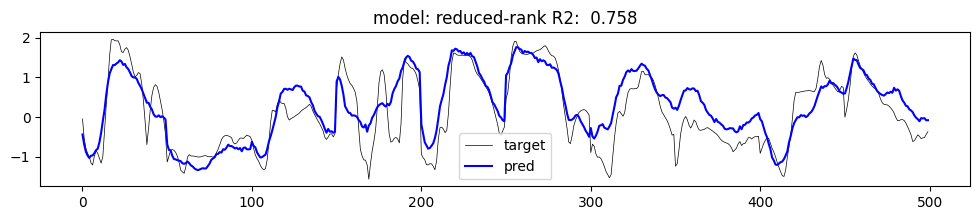

In [14]:
r2, test_pred, test_y = eval_model(dm.train, dm.test, model, model_type="reduced-rank", plot=True)

#### Train Linear Decoder

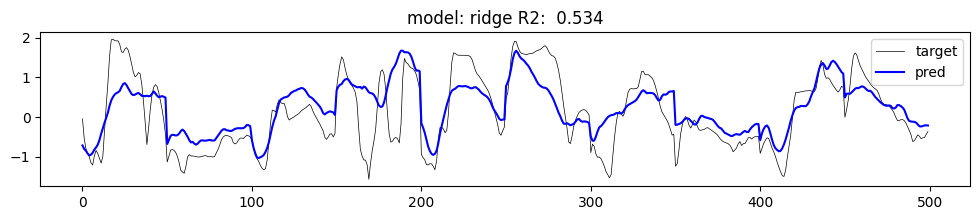

In [15]:
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
model = GridSearchCV(Ridge(), {"alpha": alphas})
r2, test_pred, test_y = eval_model(dm.train, dm.test, model, model_type="ridge", plot=True)

#### Train LSTM Decoder

In [16]:
config = {
    'data_dir': data_dir,
    'temporal_rank': 5,
    'weight_decay': 1e-1,
    'learning_rate': 1e-2,
    'batch_size': 8,
    'eid': eids[3],
    'target': 'wheel_speed',
    'lstm_hidden_size': tune.grid_search([32, 64]),
    'lstm_n_layers': tune.grid_search([3, 5]),
    'mlp_hidden_size': (256, 128, 64),
    'drop_out': 0.,
    'lr_factor': 0.1,
    'lr_patience': 5,
    'device': DEVICE,
    'n_workers': os.cpu_count()
}

In [17]:
def train_func(config):
    dm = SingleSessionDataModule(config)
    dm.setup()
    model = LSTMDecoder(dm.config)

    trainer = Trainer(
        max_epochs=500,
        devices="auto",
        accelerator="auto",
        strategy=RayDDPStrategy(),
        callbacks=[RayTrainReportCallback()],
        plugins=[RayLightningEnvironment()],
        enable_progress_bar=False,
    )
    trainer = prepare_trainer(trainer)
    trainer.fit(model, datamodule=dm)

In [18]:
results = tune_decoder(train_func, config, use_gpu=False, max_epochs=500, num_samples=1, num_workers=2)

2024-02-28 14:49:15,790	INFO data_parallel_trainer.py:344 -- GPUs are detected in your Ray cluster, but GPU training is not enabled for this trainer. To enable GPU training, make sure to set `use_gpu` to True in your scaling config.
2024-02-28 14:49:15,795	INFO data_parallel_trainer.py:344 -- GPUs are detected in your Ray cluster, but GPU training is not enabled for this trainer. To enable GPU training, make sure to set `use_gpu` to True in your scaling config.
2024-02-28 14:49:15,799	INFO data_parallel_trainer.py:344 -- GPUs are detected in your Ray cluster, but GPU training is not enabled for this trainer. To enable GPU training, make sure to set `use_gpu` to True in your scaling config.
2024-02-28 14:49:15,804	INFO data_parallel_trainer.py:344 -- GPUs are detected in your Ray cluster, but GPU training is not enabled for this trainer. To enable GPU training, make sure to set `use_gpu` to True in your scaling config.
2024-02-28 15:04:38,830	INFO tune.py:1042 -- Total run time: 923.06 

In [19]:
best_result = results.get_best_result(metric="val_loss", mode="min")
best_config = best_result.config['train_loop_config']
best_config

{'data_dir': PosixPath('/mnt/3TB/yizi/shared_decoding/data'),
 'temporal_rank': 5,
 'weight_decay': 0.1,
 'learning_rate': 0.01,
 'batch_size': 8,
 'eid': '8c33abef-3d3e-4d42-9f27-445e9def08f9',
 'target': 'wheel_speed',
 'hidden_size': 32,
 'n_layers': 3,
 'drop_out': 0.0,
 'lr_factor': 0.1,
 'lr_patience': 5,
 'device': device(type='cpu'),
 'n_workers': 16}

In [20]:
model_path = base_dir / 'models'
os.makedirs(model_path, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss', mode='min', dirpath=model_path
)

trainer = Trainer(max_epochs=500, callbacks=[checkpoint_callback], enable_progress_bar=False)
dm = SingleSessionDataModule(best_config)
dm.setup()
model = LSTMDecoder(best_config)

trainer.fit(model, datamodule=dm)
trainer.test(datamodule=dm, ckpt_path='best')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


spike data shape: (714, 50, 1255)
behavior data shape: (714, 50)
spike data shape: (714, 50, 1255)
behavior data shape: (714, 50)


/home/yizi/anaconda3/envs/ibl_foundation_model/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /mnt/3TB/yizi/shared_decoding/models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type    | Params
-------------------------------------
0 | r2_score | R2Score | 0     
1 | lstm     | LSTM    | 181 K 
2 | linear   | Linear  | 1.7 K 
-------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.734     Total estimated model params size (MB)
/home/yizi/anaconda3/envs/ibl_foundation_model/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/yizi/anaconda3/envs/ibl_foundation_model/lib/python3.11/site-packages

spike data shape: (714, 50, 1255)
behavior data shape: (714, 50)


Restoring states from the checkpoint path at /mnt/3TB/yizi/shared_decoding/models/epoch=188-step=13608.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /mnt/3TB/yizi/shared_decoding/models/epoch=188-step=13608.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.21544941356451858
         test_r2            0.8082218170166016
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/yizi/anaconda3/envs/ibl_foundation_model/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


[{'test_loss': 0.21544941356451858, 'test_r2': 0.8082218170166016}]

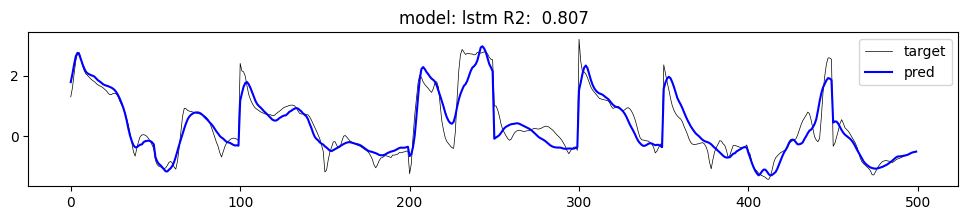

In [21]:
r2, test_pred, test_y = eval_model(dm.train, dm.test, model, model_type="lstm", plot=True)

#### Train MLP Decoder

In [7]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = {
    'data_dir': data_dir,
    'temporal_rank': 5,
    'weight_decay': tune.grid_search([1e-3, 1e-1]),
    'learning_rate': 1e-2,
    'batch_size': 8,
    'eid': eids[3],
    'target': 'wheel_speed',
    'lstm_hidden_size': 32,
    'lstm_n_layers': 3,
    'mlp_hidden_size': tune.grid_search([(128, 64, 32), (256, 128, 64)]),
    'drop_out': 0.,
    'lr_factor': 0.1,
    'lr_patience': 5,
    'device': DEVICE,
    'n_workers': os.cpu_count()
}

In [8]:
def train_func(config):
    dm = SingleSessionDataModule(config)
    dm.setup()
    model = MLPDecoder(dm.config)

    trainer = Trainer(
        max_epochs=500,
        devices="auto",
        accelerator="auto",
        strategy=RayDDPStrategy(),
        callbacks=[RayTrainReportCallback()],
        plugins=[RayLightningEnvironment()],
        enable_progress_bar=False,
    )
    trainer = prepare_trainer(trainer)
    trainer.fit(model, datamodule=dm)

In [9]:
results = tune_decoder(train_func, config, use_gpu=False, max_epochs=100, num_samples=1, num_workers=2)

2024-02-28 16:23:02,628	INFO data_parallel_trainer.py:344 -- GPUs are detected in your Ray cluster, but GPU training is not enabled for this trainer. To enable GPU training, make sure to set `use_gpu` to True in your scaling config.
2024-02-28 16:23:02,632	INFO data_parallel_trainer.py:344 -- GPUs are detected in your Ray cluster, but GPU training is not enabled for this trainer. To enable GPU training, make sure to set `use_gpu` to True in your scaling config.
2024-02-28 16:23:02,636	INFO data_parallel_trainer.py:344 -- GPUs are detected in your Ray cluster, but GPU training is not enabled for this trainer. To enable GPU training, make sure to set `use_gpu` to True in your scaling config.
2024-02-28 16:23:02,640	INFO data_parallel_trainer.py:344 -- GPUs are detected in your Ray cluster, but GPU training is not enabled for this trainer. To enable GPU training, make sure to set `use_gpu` to True in your scaling config.
2024-02-28 16:23:17,063	INFO tensorboardx.py:275 -- Removed the foll

In [10]:
best_result = results.get_best_result(metric="val_loss", mode="min")
best_config = best_result.config['train_loop_config']
best_config

{'data_dir': PosixPath('/mnt/3TB/yizi/shared_decoding/data'),
 'temporal_rank': 5,
 'weight_decay': 0.1,
 'learning_rate': 0.01,
 'batch_size': 8,
 'eid': '8c33abef-3d3e-4d42-9f27-445e9def08f9',
 'target': 'wheel_speed',
 'lstm_hidden_size': 32,
 'lstm_n_layers': 3,
 'mlp_hidden_size': (128, 64, 32),
 'drop_out': 0.0,
 'lr_factor': 0.1,
 'lr_patience': 5,
 'device': device(type='cpu'),
 'n_workers': 16}

In [11]:
model_path = base_dir / 'models'
os.makedirs(model_path, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss', mode='min', dirpath=model_path
)

trainer = Trainer(max_epochs=500, callbacks=[checkpoint_callback], enable_progress_bar=False)
dm = SingleSessionDataModule(best_config)
dm.setup()
model = MLPDecoder(best_config)

trainer.fit(model, datamodule=dm)
trainer.test(datamodule=dm, ckpt_path='best')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


spike data shape: (714, 50, 1255)
behavior data shape: (714, 50)
spike data shape: (714, 50, 1255)
behavior data shape: (714, 50)


/home/yizi/anaconda3/envs/ibl_foundation_model/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /mnt/3TB/yizi/shared_decoding/models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params
--------------------------------------------
0 | r2_score     | R2Score    | 0     
1 | input_layer  | Linear     | 160 K 
2 | hidden       | ModuleList | 10.3 K
3 | output_layer | Linear     | 33    
--------------------------------------------
171 K     Trainable params
0         Non-trainable params
171 K     Total params
0.685     Total estimated model params size (MB)
/home/yizi/anaconda3/envs/ibl_foundation_model/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve perform

spike data shape: (714, 50, 1255)
behavior data shape: (714, 50)


Restoring states from the checkpoint path at /mnt/3TB/yizi/shared_decoding/models/epoch=4-step=360.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /mnt/3TB/yizi/shared_decoding/models/epoch=4-step=360.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.530954684990694
         test_r2            0.39170128107070923
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/yizi/anaconda3/envs/ibl_foundation_model/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


[{'test_loss': 0.530954684990694, 'test_r2': 0.39170128107070923}]

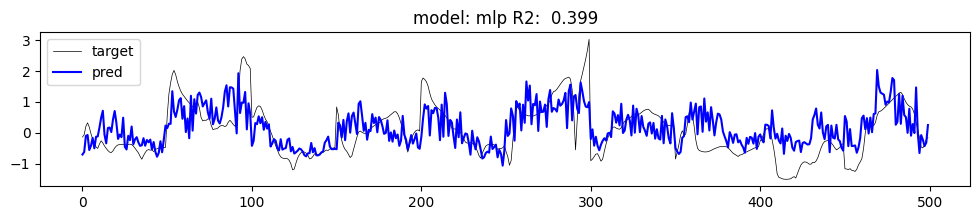

In [13]:
r2, test_pred, test_y = eval_model(dm.train, dm.test, model, model_type="mlp", plot=True)